<a href="https://colab.research.google.com/github/shelleyg-bit/canada-land-cover-classifier/blob/main/Dancing_in_a_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install rasterio rioxarray 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 6.1 MB/s 
     |████████████████████████████████| 47 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 47.5 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54611 sha256=972255b6845d5864fdf2b8667688a8691ab85e156907df5b0ac46290ac92b2b9
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [2]:
import rioxarray

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Prepare Data

## Load Data from tif to DataArray
- load landcover labels data
- load sentinel spectral data


In [3]:
 
 lc_labels_xda = rioxarray.open_rasterio('/content/drive/MyDrive/nrcan/lc_data/aoi_512x512/aoi4_lc_021')

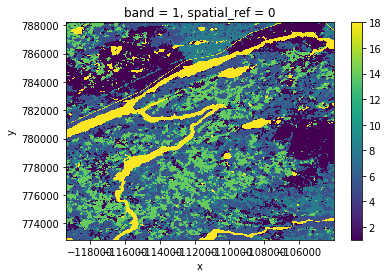

In [4]:
lc_labels_xda.plot()

In [5]:
sentinel = rioxarray.open_rasterio('/content/drive/MyDrive/nrcan/sentinel_aoi_images/aoi4_lc_021/202008.tif')

In [6]:
sentinel

<xarray.DataArray (band: 12, y: 1662, x: 1662)>
[33146928 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 6.265e+05 6.265e+05 ... 6.431e+05 6.431e+05
  * y            (y) float64 6.226e+06 6.226e+06 ... 6.209e+06 6.209e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1_max', 'B2_max', 'B3_max', 'B4_max', 'B5_max', 'B6_max...

AttributeError: ignored

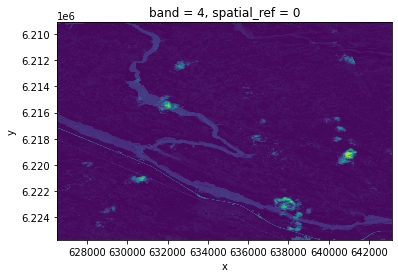

In [7]:
sentinel.sel(band=4).plot()

In [8]:
print(sentinel.rio.crs)

EPSG:32614


In [10]:
## This results in loss of data
## sentinel = sentinel.reset_coords('spatial_ref', drop=True)

## Align DataArrays
- align landcover labels to spectral data arrays
- use rioxarray.reproject_match


In [9]:
def print_xda_info(xda):
  xda_nodata = (xda == xda.rio.nodata)
  print(
      f"crs: {xda.rio.crs}\n"
      f"transform: {xda.rio.transform()}\n"
      f"shape: {xda.rio.shape}\n"
      f"resolution: {xda.rio.resolution()}\n"
      f"bounds: {xda.rio.bounds()}\n"
      f"sum: {xda.sum().item()},\n"
      f"nodata count: {xda_nodata.sum().item()}\n"
  )


In [10]:
from rasterio.enums import Resampling
lc_labels_xda_reproj = lc_labels_xda.rio.reproject(sentinel.rio.crs, resolution=(10,10), resampling=Resampling.nearest, nodata=0.0)
lc_labels_xda_reproj = lc_labels_xda_reproj.assign_coords({
    "x": sentinel.x,
    "y": sentinel.y
})
print_xda_info(lc_labels_xda)
print_xda_info(lc_labels_xda_reproj)

crs: EPSG:3978
transform: | 30.00, 0.00,-119370.27|
| 0.00,-30.00, 788205.29|
| 0.00, 0.00, 1.00|
shape: (512, 512)
resolution: (30.0, -30.0)
bounds: (-119370.2701179129, 772845.2894780128, -104010.2701179129, 788205.2894780128)
sum: 1959304,
nodata count: 0

crs: EPSG:32614
transform: | 10.00, 0.00, 626510.00|
| 0.00,-10.00, 6225720.00|
| 0.00, 0.00, 1.00|
shape: (1662, 1662)
resolution: (10.0, -10.0)
bounds: (626510.0, 6209100.0, 643130.0, 6225720.0)
sum: 18408196,
nodata count: 0



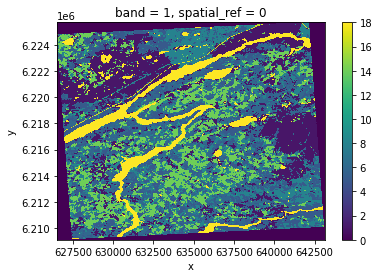

In [11]:
lc_labels_xda_reproj.plot()

In [ ]:
## this results in loss of data like attrs
## lc_labels_xda_reproj = lc_labels_xda_reproj.reset_coords('spatial_ref', drop=True).squeeze(drop=True)

In [14]:
import sys
import numpy as np
np.set_printoptions(threshold=100)
np.unique(lc_labels_xda_reproj.values, return_counts=True)

(array([ 0,  1,  2,  5,  6,  8, 10, 14, 16, 17, 18], dtype=uint8),
 array([299406, 586637,    453, 425832, 328039, 462621,  16809, 425616,
           392,   6597, 209842]))

## Load DataArrays into Dataframe
- remove nodata values

### Labels

In [12]:
labels_df = lc_labels_xda_reproj.to_dataframe(name='labels', dim_order=['x', 'y', 'band'])
labels_df.head()

spatial_ref  labels
x        y         band                     
626515.0 6225715.0 1               0       0
         6225705.0 1               0       0
         6225695.0 1               0       0
         6225685.0 1               0       0
         6225675.0 1               0       0

In [13]:
??labels_df.drop

In [ ]:
??labels_df.reset_index

In [14]:
# remove band index and drop spatial_ref column
labels_df.drop(columns=['spatial_ref'], inplace=True)
labels_df.reset_index(level='band', drop=True, inplace=True)

In [15]:
labels_df

labels
x        y                
626515.0 6225715.0       0
         6225705.0       0
         6225695.0       0
         6225685.0       0
         6225675.0       0
...                    ...
643125.0 6209145.0       0
         6209135.0       0
         6209125.0       0
         6209115.0       0
         6209105.0       0

[2762244 rows x 1 columns]

### Spectral data

In [16]:
spectral_df = sentinel.to_dataframe(name='band_values', dim_order=['x', 'y', 'band'])
spectral_df.drop(columns=['spatial_ref'], inplace=True)

In [17]:
spectral_v1 = spectral_df.unstack(['band'])
spectral_v1.columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
spectral_v1

B1      B2      B3      B4      B5      B6      B7  \
x        y                                                                   
626515.0 6225715.0  0.0209  0.0231  0.0414  0.0252  0.0711  0.1662  0.1839   
         6225705.0  0.0209  0.0222  0.0373  0.0239  0.0711  0.1662  0.1839   
         6225695.0  0.0209  0.0232  0.0405  0.0233  0.0736  0.1684  0.1885   
         6225685.0  0.0209  0.0253  0.0461  0.0299  0.0736  0.1684  0.1885   
         6225675.0  0.0209  0.0288  0.0512  0.0342  0.0817  0.1828  0.2037   
...                    ...     ...     ...     ...     ...     ...     ...   
643125.0 6209145.0  0.0240  0.0249  0.0488  0.0322  0.0899  0.2039  0.2406   
         6209135.0  0.0240  0.0276  0.0511  0.0342  0.0924  0.2134  0.2331   
         6209125.0  0.0240  0.0289  0.0583  0.0357  0.0924  0.2134  0.2331   
         6209115.0  0.0240  0.0314  0.0550  0.0353  0.0908  0.2283  0.2537   
         6209105.0  0.0240  0.0271  0.0528  0.0303  0.0908  0.2283  0.2537   

                        B8     B8A      B9     B11     B12  
x        y                                                  
626515.0 6225715.0  0.1940  0.2032  0.2059  0.1294  0.0634  
         6225705.0  0.1834  0.2032  0.2059  0.1294  0.0634  
         6225695.0  0.1910  0.1961  0.2059  0.1208  0.0576  
         6225685.0  0.1990  0.1961  0.2059  0.1208  0.0576  
         6225675.0  0.2242  0.2244  0.2059  0.1335  0.0684  
...                    ...     ...     ...     ...     ...  
643125.0 6209145.0  0.2316  0.2612  0.2878  0.1532  0.0778  
         6209135.0  0.2380  0.2643  0.2878  0.1533  0.0775  
         6209125.0  0.2668  0.2643  0.2878  0.1533  0.0775  
         6209115.0  0.2784  0.2764  0.2878  0.1606  0.0809  
         6209105.0  0.2784  0.2764  0.2878  0.1606  0.0809  

[2762244 rows x 12 columns]

In [18]:
# Merge dataframes by index
data_df = spectral_v1.join(labels_df)
data_df.head()

B1      B2      B3      B4      B5      B6      B7  \
x        y                                                                   
626515.0 6225715.0  0.0209  0.0231  0.0414  0.0252  0.0711  0.1662  0.1839   
         6225705.0  0.0209  0.0222  0.0373  0.0239  0.0711  0.1662  0.1839   
         6225695.0  0.0209  0.0232  0.0405  0.0233  0.0736  0.1684  0.1885   
         6225685.0  0.0209  0.0253  0.0461  0.0299  0.0736  0.1684  0.1885   
         6225675.0  0.0209  0.0288  0.0512  0.0342  0.0817  0.1828  0.2037   

                        B8     B8A      B9     B11     B12  labels  
x        y                                                          
626515.0 6225715.0  0.1940  0.2032  0.2059  0.1294  0.0634       0  
         6225705.0  0.1834  0.2032  0.2059  0.1294  0.0634       0  
         6225695.0  0.1910  0.1961  0.2059  0.1208  0.0576       0  
         6225685.0  0.1990  0.1961  0.2059  0.1208  0.0576       0  
         6225675.0  0.2242  0.2244  0.2059  0.1335  0.0684       0

In [19]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2762244 entries, (626515.0, 6225715.0) to (643125.0, 6209105.0)
Data columns (total 13 columns):
 #   Column  Dtype  
---  ------  -----  
 0   B1      float32
 1   B2      float32
 2   B3      float32
 3   B4      float32
 4   B5      float32
 5   B6      float32
 6   B7      float32
 7   B8      float32
 8   B8A     float32
 9   B9      float32
 10  B11     float32
 11  B12     float32
 12  labels  uint8  
dtypes: float32(12), uint8(1)
memory usage: 204.3 MB


In [20]:
data_cleaned_df = data_df[data_df['labels'] != 0]
data_cleaned_df

B1      B2      B3      B4      B5      B6      B7  \
x        y                                                                   
626515.0 6224775.0  0.0217  0.0276  0.0490  0.0328  0.0794  0.1767  0.1970   
         6224765.0  0.0217  0.0262  0.0471  0.0307  0.0794  0.1767  0.1970   
         6224755.0  0.0208  0.0245  0.0496  0.0298  0.0752  0.1688  0.2053   
         6224745.0  0.0208  0.0244  0.0482  0.0331  0.0752  0.1688  0.2053   
         6224735.0  0.0208  0.0207  0.0399  0.0291  0.0621  0.1423  0.1619   
...                    ...     ...     ...     ...     ...     ...     ...   
643115.0 6210095.0  0.0245  0.0262  0.0517  0.0314  0.0882  0.2028  0.2247   
         6210085.0  0.0245  0.0260  0.0514  0.0304  0.0882  0.2028  0.2247   
         6210075.0  0.0245  0.0269  0.0513  0.0299  0.0886  0.1963  0.2166   
         6210065.0  0.0245  0.0264  0.0496  0.0288  0.0886  0.1963  0.2166   
         6210055.0  0.0208  0.0269  0.0491  0.0301  0.0784  0.1861  0.2101   

                        B8     B8A      B9     B11     B12  labels  
x        y                                                          
626515.0 6224775.0  0.2292  0.2173  0.2320  0.1354  0.0641       1  
         6224765.0  0.2270  0.2173  0.2320  0.1354  0.0641       1  
         6224755.0  0.2144  0.2060  0.2097  0.1223  0.0592       1  
         6224745.0  0.2136  0.2060  0.2097  0.1223  0.0592       1  
         6224735.0  0.1824  0.1775  0.2097  0.0942  0.0487       1  
...                    ...     ...     ...     ...     ...     ...  
643115.0 6210095.0  0.2352  0.2437  0.2361  0.1458  0.0725      14  
         6210085.0  0.2250  0.2437  0.2361  0.1458  0.0725      14  
         6210075.0  0.2182  0.2449  0.2361  0.1425  0.0705       5  
         6210065.0  0.2196  0.2449  0.2361  0.1425  0.0705       5  
         6210055.0  0.2238  0.2298  0.2424  0.1414  0.0696       5  

[2462838 rows x 13 columns]

In [21]:
data_cleaned_df['labels'].value_counts()

1     586637
8     462621
5     425832
14    425616
6     328039
18    209842
10     16809
17      6597
2        453
16       392
Name: labels, dtype: int64

# Modelling

In [22]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Train a baseline Random Forest

- use sklearn
- compute balanced_accuracy_score


### Sample and Normalize Data

In [50]:
SAMPLE_SIZE = 500000
sampled_df = data_cleaned_df[0:SAMPLE_SIZE]
sampled_df['labels'].value_counts()

1     135997
14    103185
5      86871
8      68771
6      62331
18     35683
10      5426
17      1598
2         83
16        55
Name: labels, dtype: int64

In [51]:
## TODO: look into how scaling works
Y = sampled_df.labels
X = sampled_df.drop(columns=['labels'])
columns = X.columns

scalar = StandardScaler()
X = scalar.fit_transform(X)

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(400000, 12) (100000, 12) (400000,) (100000,)


In [62]:
clf=RandomForestClassifier(n_estimators=100, max_features='sqrt', min_samples_leaf=10)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=10)

In [60]:
Y_pred = clf.predict(X_test)

In [61]:
print("Balanced Accuracy:", metrics.balanced_accuracy_score(Y_test, Y_pred))

Balanced Accuracy: 0.5016637361618486


In [56]:
print("Normal Accuracy:", metrics.accuracy_score(Y_test, Y_pred, normalize=True))

Normal Accuracy: 0.68667


### Confusion Matrix

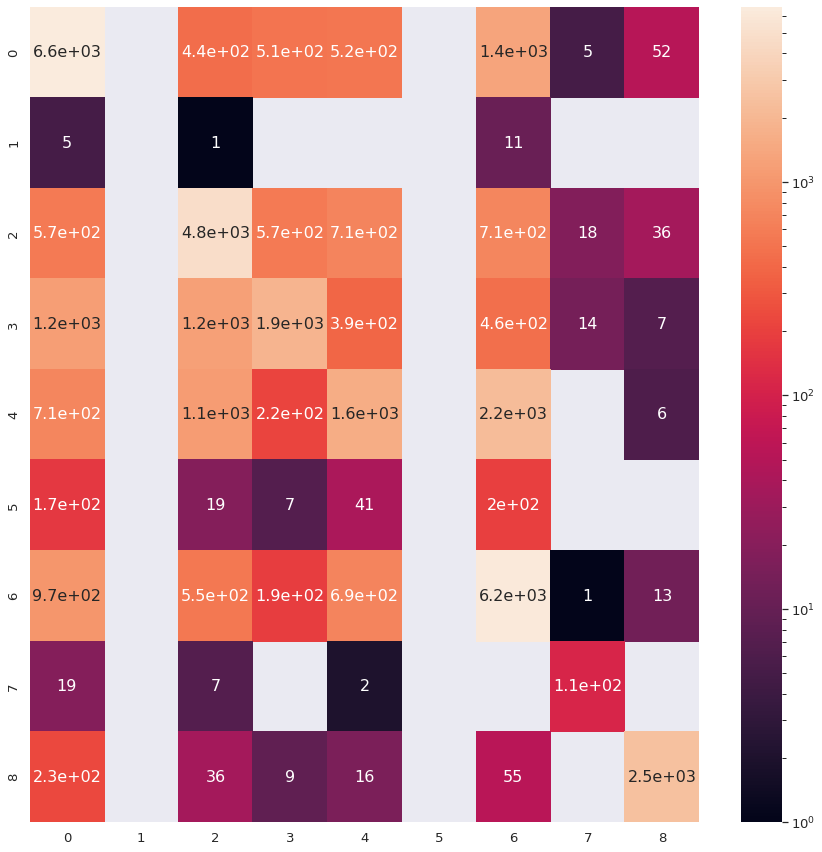

In [30]:
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
results = confusion_matrix(Y_test, Y_pred)
df_cm = pd.DataFrame(results, range(results.shape[0]), range(results.shape[0]))
plt.figure(figsize=(15,15))
sns.set(font_scale=1.2) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, norm=LogNorm()) # font size
plt.show()

#TODO: Add labels in confusion matrix by actual labels

In [64]:
??list.sort

In [32]:
# Some classes(label 1 & 5) are missing in train data, which are in test data
from operator import itemgetter
import numpy as np
def get_unique_counts(x):
  counts = np.unique(x, return_counts=True)
  count_tuple = [(v, c) for v,c in zip(counts[0], counts[1])]
  count_tuple.sort(key=lambda item: item[1])
  print(count_tuple)

get_unique_counts(Y_train)
get_unique_counts(Y_test)
get_unique_counts(Y_pred)
print(sampled_df['labels'].value_counts())

[(2, 66), (17, 499), (10, 1699), (18, 11749), (6, 19969), (8, 23919), (5, 30107), (14, 34143), (1, 37849)]
[(2, 17), (17, 139), (10, 435), (18, 2851), (6, 5115), (8, 5920), (5, 7429), (14, 8599), (1, 9495)]
[(17, 149), (18, 2616), (6, 3360), (8, 3978), (5, 8218), (1, 10452), (14, 11227)]
1     47344
14    42742
5     37536
8     29839
6     25084
18    14600
10     2134
17      638
2        83
Name: labels, dtype: int64


**TODO**: Figure out why the model performs poorly on 10 by good enough on 17. Get legend for land cover types

## Test on test dataset

In [33]:
demo_df = pd.read_csv('/content/drive/MyDrive/nrcan/test_data/demo_site.csv')

In [34]:
demo_df.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,land_cover
0,0.0269,0.0323,0.0486,0.0336,0.0826,0.2044,0.2381,0.2459,0.2557,0.1522,0.0807,0.2563,8.0
1,0.0261,0.0310,0.0492,0.0307,0.0814,0.2132,0.2465,0.2552,0.2593,0.1454,0.0743,0.2621,1.0
2,0.0260,0.0285,0.0438,0.0239,0.0693,0.1920,0.2221,0.2269,0.2242,0.1182,0.0574,0.2336,1.0
3,0.0272,0.0295,0.0406,0.0234,0.0581,0.1477,0.1752,0.1783,0.1839,0.0773,0.0370,0.1854,1.0
4,0.0248,0.0293,0.0451,0.0307,0.0769,0.2037,0.2391,0.2461,0.2592,0.1472,0.0764,0.2564,8.0


# EDA


In [35]:
sorted(demo_df['land_cover'].value_counts().items(), key=itemgetter(0))

[(1.0, 1295963),
 (2.0, 229),
 (5.0, 754883),
 (6.0, 319587),
 (8.0, 327876),
 (10.0, 32747),
 (12.0, 96),
 (14.0, 1786474),
 (15.0, 389203),
 (16.0, 8532),
 (17.0, 24855),
 (18.0, 309555)]

In [78]:
??demo_df.reindex

In [36]:
new_columns = [f"B0{i}" for i in range(1, 9)] + ['B8A', 'B09', 'B11', 'B12', 'land_cover']
demo_df_v1 = demo_df.reindex(labels=new_columns, axis=1, copy=False)

In [37]:
demo_df_v1.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,land_cover
0,0.0269,0.0323,0.0486,0.0336,0.0826,0.2044,0.2381,0.2459,0.2563,0.2557,0.1522,0.0807,8.0
1,0.0261,0.0310,0.0492,0.0307,0.0814,0.2132,0.2465,0.2552,0.2621,0.2593,0.1454,0.0743,1.0
2,0.0260,0.0285,0.0438,0.0239,0.0693,0.1920,0.2221,0.2269,0.2336,0.2242,0.1182,0.0574,1.0
3,0.0272,0.0295,0.0406,0.0234,0.0581,0.1477,0.1752,0.1783,0.1854,0.1839,0.0773,0.0370,1.0
4,0.0248,0.0293,0.0451,0.0307,0.0769,0.2037,0.2391,0.2461,0.2564,0.2592,0.1472,0.0764,8.0


In [45]:
Y_large_test = demo_df_v1['land_cover']
X_large_test = demo_df_v1.drop(columns=['land_cover'])

scalar = StandardScaler()
X_large_test = scalar.fit_transform(X_large_test)

In [63]:
Y_large_pred = clf.predict(X_large_test)

In [64]:
print("Balanced Accuracy:", metrics.balanced_accuracy_score(Y_large_test, Y_large_pred))

Balanced Accuracy: 0.23021097271350885


In [49]:
sampled_df.head()

B1      B2      B3      B4      B5      B6      B7  \
x        y                                                                   
626515.0 6224775.0  0.0217  0.0276  0.0490  0.0328  0.0794  0.1767  0.1970   
         6224765.0  0.0217  0.0262  0.0471  0.0307  0.0794  0.1767  0.1970   
         6224755.0  0.0208  0.0245  0.0496  0.0298  0.0752  0.1688  0.2053   
         6224745.0  0.0208  0.0244  0.0482  0.0331  0.0752  0.1688  0.2053   
         6224735.0  0.0208  0.0207  0.0399  0.0291  0.0621  0.1423  0.1619   

                        B8     B8A      B9     B11     B12  labels  
x        y                                                          
626515.0 6224775.0  0.2292  0.2173  0.2320  0.1354  0.0641       1  
         6224765.0  0.2270  0.2173  0.2320  0.1354  0.0641       1  
         6224755.0  0.2144  0.2060  0.2097  0.1223  0.0592       1  
         6224745.0  0.2136  0.2060  0.2097  0.1223  0.0592       1  
         6224735.0  0.1824  0.1775  0.2097  0.0942  0.0487       1

In [66]:

sorted(sampled_df['labels'].value_counts().items(), key=itemgetter(0))

[(1, 135997),
 (2, 83),
 (5, 86871),
 (6, 62331),
 (8, 68771),
 (10, 5426),
 (14, 103185),
 (16, 55),
 (17, 1598),
 (18, 35683)]